In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import librosa
import pandas as pd

# Path to dataset
dataset_path = '/content/drive/My Drive/dataset/'

In [6]:
import numpy as np

# Path to preprocessed data
preprocessed_data_path = '/content/drive/My Drive/dataset/preprocessed_data/vgg16_data/'

# Load the training and validation data
train_data = np.load(preprocessed_data_path + 'vgg16_train.npz')
val_data = np.load(preprocessed_data_path + 'vgg16_val.npz')

# Load the data description
with open('/content/drive/My Drive/dataset/preprocessed_data/preprocessed_data_description.txt', 'r') as f:
    data_description = f.read()

print("Training data loaded.")
print("Validation data loaded.")
print("\nData Description:")
print(data_description)

Training data loaded.
Validation data loaded.

Data Description:

Dataset: HELMET Dataset

Original Data Locations (Downloaded from Kaggle):
- Base Dataset Path: /root/.cache/kagglehub/datasets/kronomy/helmet-dataset-by-osf-lite/versions/1/helmet-dataset (This is the local path where the dataset was downloaded by kagglehub)
- Annotation Files (CSV): /root/.cache/kagglehub/datasets/kronomy/helmet-dataset-by-osf-lite/versions/1/helmet-dataset/annotation/annotation
- Data Split File (CSV): /root/.cache/kagglehub/datasets/kronomy/helmet-dataset-by-osf-lite/versions/1/helmet-dataset/data_split.csv (Note: This file was used for initial understanding, but a custom split was applied.)

Preprocessed Data Output Locations (Saved to Google Drive):
- Base Save Directory: /content/drive/My Drive/dataset/preprocessed_data
- YOLO Annotations: /content/drive/My Drive/dataset/preprocessed_data/yolo_annotations (Saved as text files (.txt) with one file per image, containing annotations in YOLO format: c

In [7]:
# Extract image patches and labels from the loaded data
train_images = train_data['image_patches']
train_labels = train_data['labels']
val_images = val_data['image_patches']
val_labels = val_data['labels']

print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Training images shape: (3201, 224, 224, 3)
Training labels shape: (3201,)
Validation images shape: (365, 224, 224, 3)
Validation labels shape: (365,)


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the VGG16 model pre-trained on ImageNet
# We don't include the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
# The number of units in the output layer should match the number of binary classes (helmet/no helmet)
predictions = Dense(2, activation='softmax')(x) # 2 units for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Create a new label map for binary classification (helmet or no helmet)
# Assuming any label containing "Helmet" means with helmet, and "NoHelmet" means without helmet.
# We'll prioritize "NoHelmet" if both are present in a label string.
binary_label_map = {}
for original_label in np.unique(np.concatenate((train_labels, val_labels))):
    if 'NoHelmet' in original_label:
        binary_label_map[original_label] = 1 # 1 for without helmet
    elif 'Helmet' in original_label:
        binary_label_map[original_label] = 0 # 0 for with helmet
    else:
        # Handle cases that don't clearly fit into either category if any
        # For now, we'll print a warning and assign a default or skip
        print(f"Warning: Label '{original_label}' does not contain 'Helmet' or 'NoHelmet'. Assigning to 'without helmet' (0).")
        binary_label_map[original_label] = 1 # Assign to without helmet by default


train_labels_binary = np.array([binary_label_map[label] for label in train_labels])
val_labels_binary = np.array([binary_label_map[label] for label in val_labels])

print("Processed training labels (binary):", train_labels_binary)
print("Processed validation labels (binary):", val_labels_binary)

print(train_labels_binary.size)

Processed training labels (binary): [0 1 0 ... 0 0 1]
Processed validation labels (binary): [1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0
 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0
 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3201


In [10]:
print(f"Data type of train_images: {train_images.dtype}")
print(f"Data type of train_labels: {train_labels.dtype}")
print(f"Data type of val_images: {val_images.dtype}")
print(f"Data type of val_labels: {val_labels.dtype}")

Data type of train_images: uint8
Data type of train_labels: <U39
Data type of val_images: uint8
Data type of val_labels: <U29


In [11]:
# Find unique labels in the training and validation datasets
unique_train_labels = np.unique(train_labels)
unique_val_labels = np.unique(val_labels)

print("Unique labels in training data:", unique_train_labels)
print("Unique labels in validation data:", unique_val_labels)

Unique labels in training data: ['DHelmet' 'DHelmetP0Helmet' 'DHelmetP0NoHelmet'
 'DHelmetP0NoHelmetP1Helmet' 'DHelmetP0NoHelmetP1NoHelmet'
 'DHelmetP0NoHelmetP1NoHelmetP2Helmet'
 'DHelmetP0NoHelmetP1NoHelmetP2NoHelmet' 'DHelmetP1Helmet'
 'DHelmetP1HelmetP2Helmet' 'DHelmetP1HelmetP2NoHelmet' 'DHelmetP1NoHelmet'
 'DHelmetP1NoHelmetP2Helmet' 'DHelmetP1NoHelmetP2NoHelmet' 'DNoHelmet'
 'DNoHelmetP0NoHelmet' 'DNoHelmetP0NoHelmetP1NoHelmet'
 'DNoHelmetP0NoHelmetP1NoHelmetP2NoHelmet' 'DNoHelmetP1Helmet'
 'DNoHelmetP1HelmetP2Helmet' 'DNoHelmetP1NoHelmet'
 'DNoHelmetP1NoHelmetP2NoHelmet' 'DNoHelmetP1NoHelmetP2NoHelmetP3NoHelmet']
Unique labels in validation data: ['DHelmet' 'DHelmetP0NoHelmet' 'DHelmetP1Helmet' 'DHelmetP1HelmetP2Helmet'
 'DHelmetP1NoHelmet' 'DHelmetP1NoHelmetP2Helmet'
 'DHelmetP1NoHelmetP2NoHelmet' 'DNoHelmet' 'DNoHelmetP0NoHelmetP1NoHelmet'
 'DNoHelmetP1Helmet' 'DNoHelmetP1NoHelmet' 'DNoHelmetP1NoHelmetP2NoHelmet']


# Task
Create data loaders with on-the-fly augmentations for the training and validation datasets.

## Define augmentations

### Subtask:
Specify the types of augmentations to apply (e.g., rotations, flips, zooms).


**Reasoning**:
Define the augmentation parameters for training and validation data.



In [ ]:
train_datagen_params = {
    'rotation_range': 20,
    #'width_shift_range': 0.1,
    #'height_shift_range': 0.1,
    'shear_range': 0.2,
    # 'zoom_range': 0.2, # Removed zoom range
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

val_datagen_params = {
    'rescale': 1./255 # Only apply rescaling for validation data
}

## Create imagedatagenerators

### Subtask:
Instantiate `ImageDataGenerator` objects for training and validation, applying the defined augmentations to the training generator.


**Reasoning**:
Instantiate ImageDataGenerator objects for training and validation using the defined parameters.



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(**train_datagen_params)
val_datagen = ImageDataGenerator(**val_datagen_params)

print("ImageDataGenerator instances created for training and validation.")

ImageDataGenerator instances created for training and validation.


## Create data loaders

### Subtask:
Use the `flow` method of the `ImageDataGenerator`s to create data loaders for the training and validation datasets.


**Reasoning**:
Create data loaders using the .flow() method of the ImageDataGenerator instances for both training and validation datasets with specified batch size and shuffling settings.



In [ ]:
batch_size = 32

train_generator = train_datagen.flow(train_images, train_labels_binary, batch_size=batch_size, shuffle=True)
val_generator = val_datagen.flow(val_images, val_labels_binary, batch_size=batch_size, shuffle=False)

print("Data generators created for training and validation.")

Data generators created for training and validation.


In [ ]:
# Train the model with binary labels
history = model.fit(train_generator, epochs=5, validation_data=val_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 64s 486ms/step - accuracy: 0.6573 - loss: 14.6867 - val_accuracy: 0.7068 - val_loss: 0.6774
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 400ms/step - accuracy: 0.7350 - loss: 0.5566 - val_accuracy: 0.7068 - val_loss: 0.6731
Epoch 3/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 401ms/step - accuracy: 0.7434 - loss: 0.5530 - val_accuracy: 0.7068 - val_loss: 0.6564
Epoch 4/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 406ms/step - accuracy: 0.7527 - loss: 0.4968 - val_accuracy: 0.7068 - val_loss: 0.6519
Epoch 5/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 401ms/step - accuracy: 0.7539 - loss: 0.4950 - val_accuracy: 0.7068 - val_loss: 0.6477


In [ ]:
history = model.fit(train_generator, epochs=1, validation_data=val_generator)

101/101 ━━━━━━━━━━━━━━━━━━━━ 44s 434ms/step - accuracy: 0.7382 - loss: 0.5898 - val_accuracy: 0.7068 - val_loss: 0.6224


In [ ]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(val_images, val_labels_binary, verbose=0)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Loss: 0.4719
Validation Accuracy: 0.7945


In [ ]:
# Define the path to save the model
model_save_path = '/content/drive/My Drive/dataset/vgg16_helmet_detection_model.keras'

# Save the trained model
model.save(model_save_path)

print(f"Model saved successfully to: {model_save_path}")

Model saved successfully to: /content/drive/My Drive/dataset/vgg16_helmet_detection_model.keras


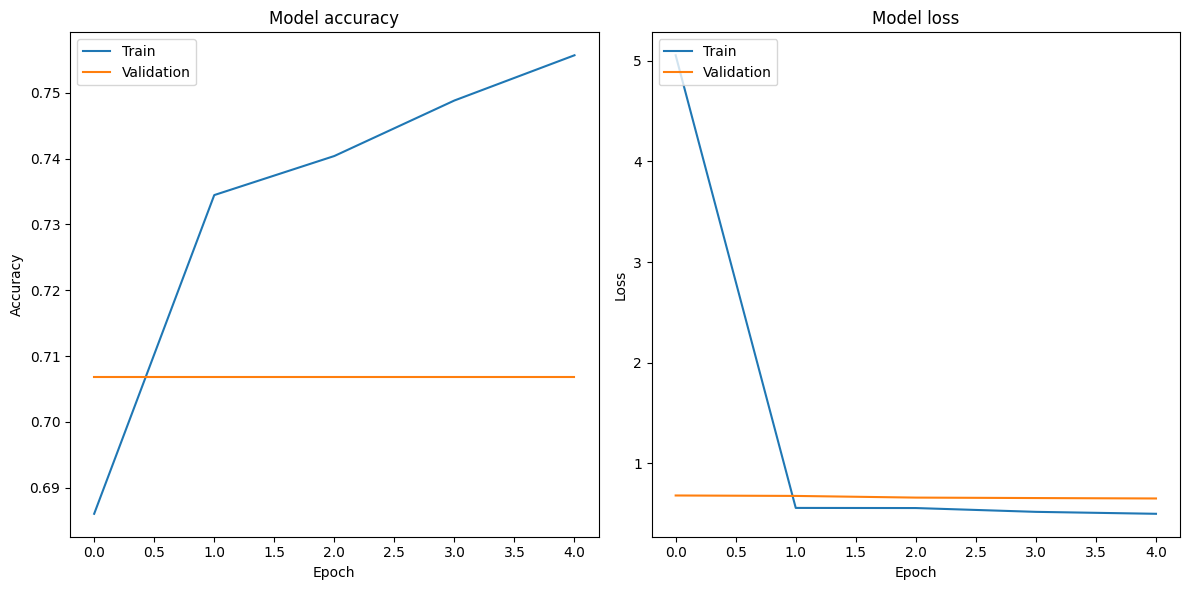

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
import numpy as np
# Path to preprocessed data
preprocessed_data_path = '/content/drive/My Drive/dataset/preprocessed_data/vgg16_data/'

# Load the testing data
try:
    test_data = np.load(preprocessed_data_path + 'vgg16_test.npz')
    print("Testing data loaded.")
except FileNotFoundError:
    print(f"Error: vgg16_test.npz not found at {preprocessed_data_path}. Please ensure the file exists.")
    test_data = None # Set test_data to None to prevent further errors

Testing data loaded.


In [17]:
from tensorflow.keras.models import load_model

# Define the path to load the model
model_load_path = '/content/drive/My Drive/dataset/vgg16_helmet_detection_model.keras'

# Load the trained model
loaded_model = load_model(model_load_path)

print(f"Model loaded successfully from: {model_load_path}")

Model loaded successfully from: /content/drive/My Drive/dataset/vgg16_helmet_detection_model.keras


In [19]:
if test_data is not None:
    # Extract image patches and labels from the loaded data
    test_images = test_data['image_patches']
    test_labels = test_data['labels']

    print(f"Testing images shape: {test_images.shape}")
    print(f"Testing labels shape: {test_labels.shape}")

    # Apply the same binary label mapping to the test labels
    # We assume binary_label_map is already defined from previous steps
    test_labels_binary = np.array([binary_label_map.get(label, 0) for label in test_labels]) # Use .get with a default in case of unseen labels

    print("Processed testing labels (binary):", test_labels_binary)
    print(test_labels_binary.size)

    # Evaluate the model on the test data
    print("\nEvaluating model on test data...")
    test_loss, test_accuracy = loaded_model.evaluate(test_images, test_labels_binary, verbose=0)

    # Get predictions for calculating additional metrics
    test_predictions = loaded_model.predict(test_images)
    test_predicted_classes = np.argmax(test_predictions, axis=1)

    from sklearn.metrics import precision_score, recall_score, f1_score

    # Calculate precision, recall, and F1 score
    test_precision = precision_score(test_labels_binary, test_predicted_classes)
    test_recall = recall_score(test_labels_binary, test_predicted_classes)
    test_f1 = f1_score(test_labels_binary, test_predicted_classes)


    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

else:
    print("Skipping model evaluation on test data as test data could not be loaded.")

Testing images shape: (1012, 224, 224, 3)
Testing labels shape: (1012,)
Processed testing labels (binary): [1 1 0 ... 0 0 0]
1012

Evaluating model on test data...
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step
Test Loss: 0.4902
Test Accuracy: 0.7688
Test Precision: 0.8889
Test Recall: 0.3019
Test F1 Score: 0.4507


In [13]:
import matplotlib.pyplot as plt

# Get a batch of augmented images and labels from the training generator
augmented_images, augmented_labels = next(train_generator)

# Display a few augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].astype("uint8")) # Display as uint8 for proper image rendering
    plt.title(f"Label: {augmented_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

NameError: name 'train_generator' is not defined

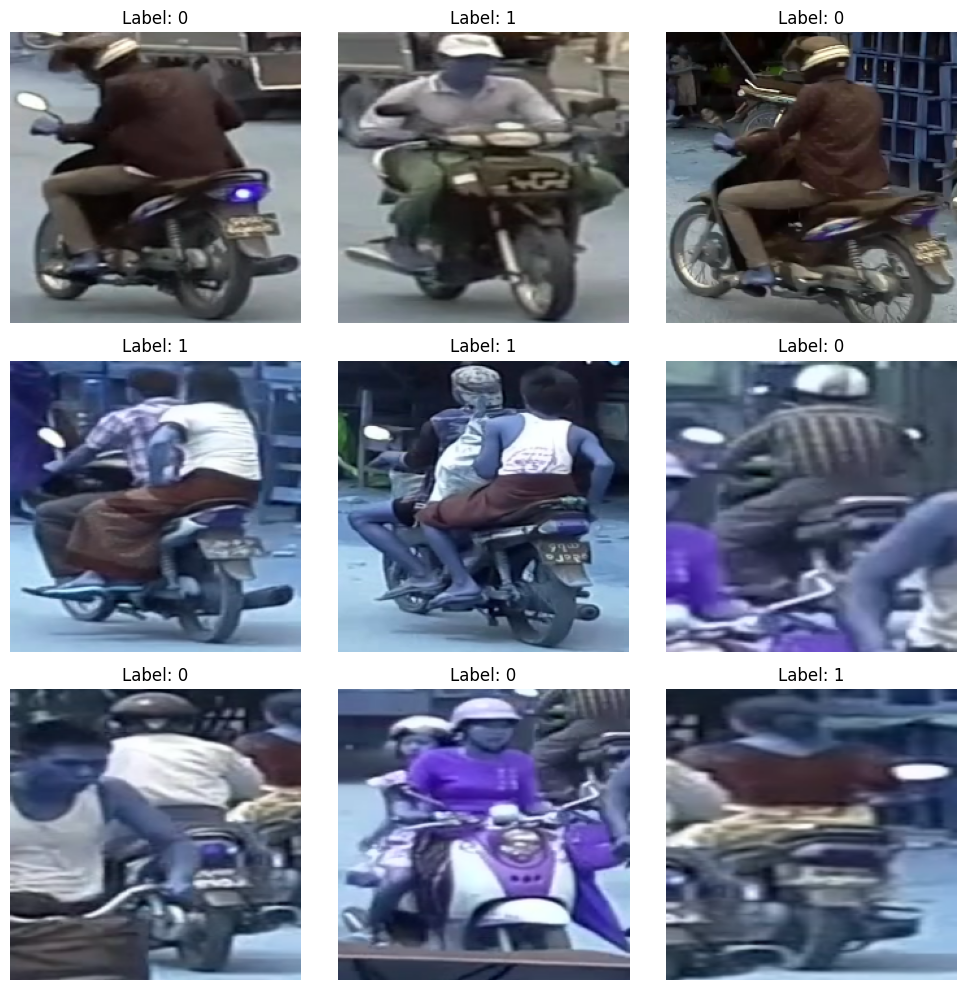

In [14]:
import matplotlib.pyplot as plt

# Display a few original training images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i].astype("uint8")) # Display as uint8 for proper image rendering
    plt.title(f"Label: {train_labels_binary[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

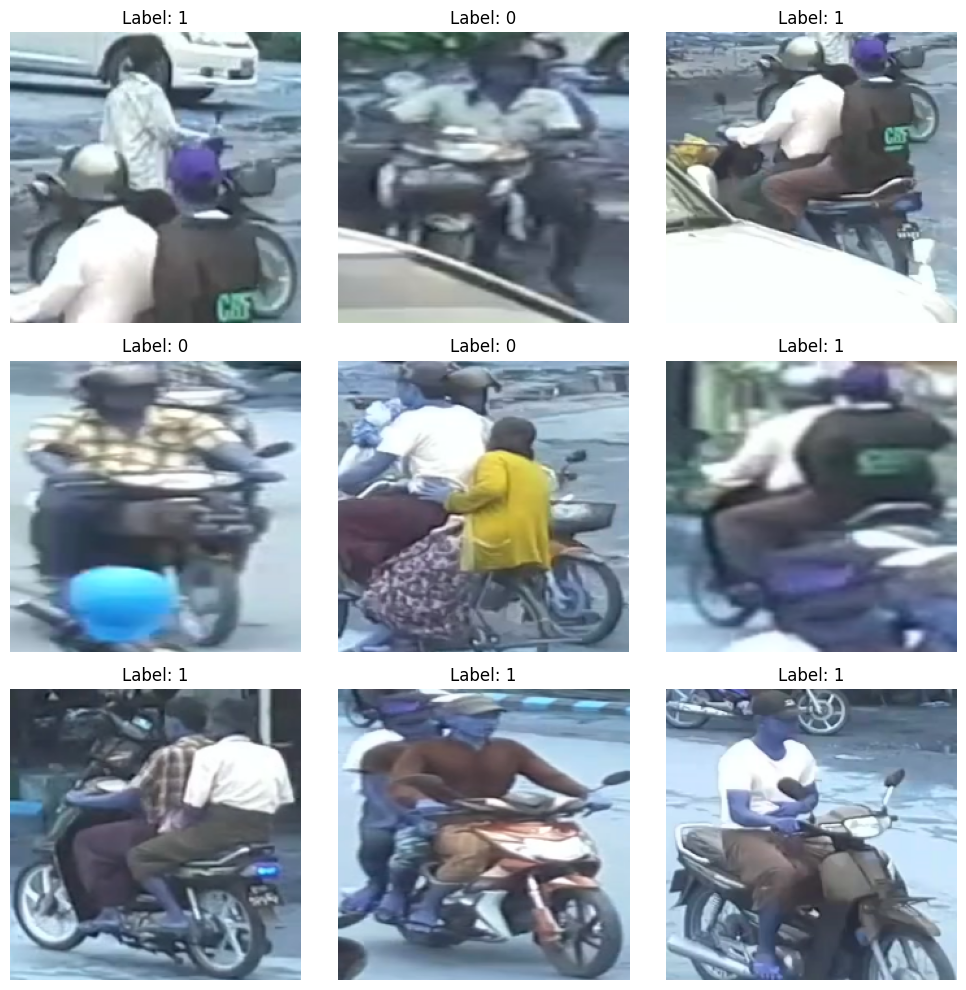

In [ ]:
# Get a batch of validation images and labels from the validation generator
val_augmented_images, val_augmented_labels = next(val_generator)

# Display a few validation images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # Ensure the image data is in the correct format for display (e.g., uint8)
    # If val_datagen_params includes rescale, the data will be float. Convert back to uint8 for display.
    if 'rescale' in val_datagen_params:
        img_to_display = (val_augmented_images[i] * 255).astype("uint8")
    else:
        img_to_display = val_augmented_images[i].astype("uint8")

    plt.imshow(img_to_display)
    plt.title(f"Label: {val_augmented_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
import numpy as np

# Define the path to load the model
model_load_path = '/content/drive/My Drive/dataset/vgg16_helmet_detection_model.keras'

# Load the trained model
loaded_model = load_model(model_load_path)

print(f"Model loaded successfully from: {model_load_path}")

# Example of making a prediction on a single image (replace with your new image data)
# Let's use the first image from the test set as an example
if test_data is not None:
    test_images = test_data['image_patches']
    sample_image = test_images[0]
    # The model expects a batch of images, so we need to add an extra dimension
    sample_image = np.expand_dims(sample_image, axis=0)

    # Make a prediction
    predictions = loaded_model.predict(sample_image)

    print("\nModel output (probabilities):", predictions)

    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)

    print("Predicted class (0: helmet, 1: no helmet):", predicted_class[0])
else:
    print("\nTest data not available to demonstrate prediction.")

Model loaded successfully from: /content/drive/My Drive/dataset/vgg16_helmet_detection_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Model output (probabilities): [[0.5592941  0.44070593]]
Predicted class (0: helmet, 1: no helmet): 0


In [10]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

TensorFlow version: 2.19.0
Keras version: 3.10.0


Number of false negatives: 222


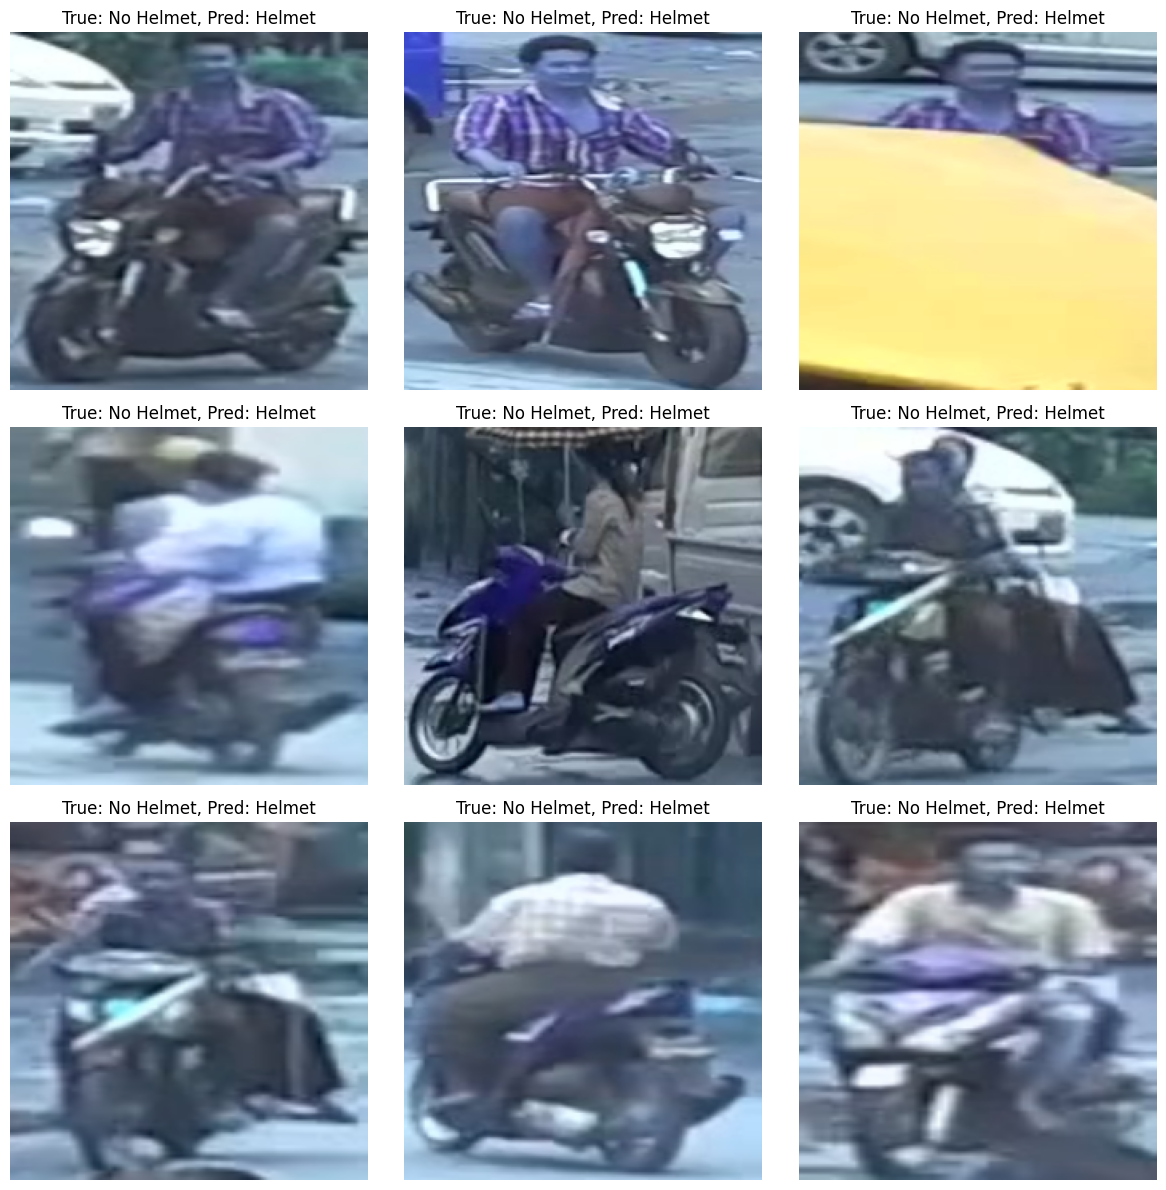

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_images, test_labels_binary, and test_predicted_classes are available from previous steps

# Find indices where the true label is 'no helmet' (1) but the predicted label is 'helmet' (0)
false_negatives_indices = np.where((test_labels_binary == 1) & (test_predicted_classes == 0))[0]

print(f"Number of false negatives: {len(false_negatives_indices)}")

# Display a few false negative examples
plt.figure(figsize=(12, 12))
num_to_display = min(9, len(false_negatives_indices)) # Display up to 9 examples

if num_to_display > 0:
    for i in range(num_to_display):
        index_to_display = false_negatives_indices[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(test_images[index_to_display].astype("uint8"))
        plt.title(f"True: No Helmet, Pred: Helmet")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No false negatives to display.")

# Task
Write a formal report documenting the training process of the helmet detection algorithm based on the provided information about Annotation Processing & Data Preparation, Augmentation and Data Loading, Model Architecture, Training Procedure, and Evaluation and Performance Metrics. Include details on data preparation, augmentation, model architecture, training configuration, training results, and evaluation metrics (Accuracy, Precision, Recall, F1 Score) on the test set.

## Report introduction

### Subtask:
Start the report with an introduction outlining the goal of the project (helmet detection) and the approach taken (fine-tuning VGG16).


**Reasoning**:
Write the introductory paragraph for the report as requested by the subtask.



In [1]:
report = """
# Helmet Detection Algorithm Training Report

## Introduction

This report details the development and training of a helmet detection algorithm. The primary objective of this project is to accurately identify whether individuals in images are wearing helmets or not. This is crucial for various applications, including enhancing road safety monitoring and enforcing safety regulations. Our approach involves leveraging the power of deep learning, specifically by fine-tuning a pre-trained VGG16 convolutional neural network model. VGG16, initially trained on the large ImageNet dataset, provides a strong foundation for feature extraction, which is then adapted for our specific binary classification task of helmet detection.
"""
print(report)


# Helmet Detection Algorithm Training Report

## Introduction

This report details the development and training of a helmet detection algorithm. The primary objective of this project is to accurately identify whether individuals in images are wearing helmets or not. This is crucial for various applications, including enhancing road safety monitoring and enforcing safety regulations. Our approach involves leveraging the power of deep learning, specifically by fine-tuning a pre-trained VGG16 convolutional neural network model. VGG16, initially trained on the large ImageNet dataset, provides a strong foundation for feature extraction, which is then adapted for our specific binary classification task of helmet detection.

